## Server

###  Imports

In [16]:
from langchain_openai import ChatOpenAI

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph
from langgraph.graph.message import add_messages

from langchain_core.messages import (
    HumanMessage, 
    AIMessage, 
    SystemMessage,
    BaseMessage,
    trim_messages
)

from langchain_core.prompts import (
    ChatPromptTemplate, 
    MessagesPlaceholder,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate
)

from typing import Sequence

from typing_extensions import Annotated, TypedDict

import base64
from mimetypes import guess_type
import re
import os
from urllib.request import urlretrieve

### Initialization

In [18]:
model = ChatOpenAI(model="gpt-4o")

### Data prep functions

In [19]:
trimmer = trim_messages(
    max_tokens=8,
    strategy="last",
    token_counter=len,
    include_system=True,
    allow_partial=False,
    # start_on="human",
)

In [20]:
def message_to_string(trimmings):
    n = 1
    result = ""
    for message in trimmings:
        result += "\n" + f"Instruction Number {n}:" + message.content
        n += 1
    result += "End of Instructioins you have given so far."
    return result

## alternative examples and prompts

In [ ]:
# examples = [
#     {
#         "messages": [
#             "The JetBot detected a tent wall with lights directly ahead and turned left sharply. [t90]",
#             "The JetBot moved forward for 2 seconds through an opening to investigate objects of interest. [f2]",
#             "The JetBot detected the dog in the center third of the screen but slightly to the right and turned left slightly to align. [t15]",
#             "The JetBot headed straight in the general direction of the dog. Will correct course next move. [f2]",
#             "The JetBot overadjusted to the left, causing the dog to shift back slightly right toward the center. [t-5]",
#             "The JetBot confirmed the dog is fully centered in the middle third of the screen. [t5]",
#             "The JetBot moved forward to approach the dog and reached it. [f2]",
#         ],
#         "image_input": (
#             "The dog is fully centered in the middle third of the screen, "
#             "with no smoke or obstacles. Nothing can be seen surrounding the dog."
#         ),
#         "expected_response": (
#             "The dog is fully centered in the middle third of the screen, with no smoke or obstacles. "
#             "There is nothing behind the dog so turning around to search for a new dog. [t100]<<d>>"
#         ),
#     },
#     {
#         "messages": [
#             "The JetBot moved forward into a smokey environment. [f3]",
#             "The JetBot detected the dog slightly off-center in a smokey environment in the 1st quarter from the right of the screen and turned right sharply to align. [t30]",
#             "The JetBot overcorrected, causing the dog to shift slightly right into the 2nd quarter. [t-5]",
#             "The JetBot headed straight in the general direction of the dog. Will correct course next move. [f2]",
#             "The JetBot realigned, and the dog is now in the center-left of the screen. [t5]",
#             "The JetBot moved forward and positioned itself directly in front of the dog. [f2]",
#         ],
#         "image_input": (
#             "The dog is now fully centered in the middle third of the screen. "
#             "There is another dog-like object that can be seen in the distance behind the current dog."
#         ),
#         "expected_response": (
#             "The dog is now fully centered in the middle third of the screen. This dog has been found. "
#             "Turn slightly to the right to avoid this dog, and move forward in the next instruction to approach the dog behind. [t-40]<<d>>"
#         ),
#     },
#     {
#         "messages": [
#             "The JetBot encountered an obstale covering the complete left half of its vision and turned right to avoid it. [t-45]",
#             "The JetBot continued turning right to clear the obstacle. [t-15]",
#             "The JetBot detected the dog in the 3rd quarter from the left of the screen and turned slightly right to align. [t-5]",
#             "The JetBot headed straight in the general direction of the dog. Will correct course next move. [f2]",
#             "The JetBot adjusted its path and confirmed the dog is now in the center-left of the screen. [t5]",
#             "The JetBot moved forward to approach the dog and stopped in front of it. [f1]",
#         ],
#         "image_input": "The dog is fully visible in the middle third of the screen. The tent wall lines the background of the dog.",
#         "expected_response": (
#             "The dog is fully visible in the middle third of the screen. The dog is found. "
#             "Turn to avoid the tent and to begin search for a new dog. [t-90]<<d>>"
#         ),
#     },
#     {
#         "messages": [
#             "The JetBot detected a tent wall lined with lights directly in front covering entire screen and turned right to avoid it. [t-60]",
#             "The JetBot continued turning right to avoid the same tent wall. [t-20]",
#             "The JetBot moved forward explore further objects of interest in the smoke. [f2]",
#             "The JetBot detected what might be a dog in the smoke slightly off-center in the 2nd quarter from the left and turned left slightly to align. [t20]",
#             "The JetBot headed straight in the general direction of the dog. Will correct course next move. [f2]",
#             "The JetBot overadjusted to the left, causing the dog to shift slightly back to the center. [t-5]",
#             "The JetBot confirmed the dog is fully centered in the middle third of the screen and moved forward to reach it. [f3]",
#         ],
#         "image_input": (
#             "The dog is now fully centered in the middle third of the screen. "
#             "There is an open space to the left of the dog with an object in the distance."
#         ),
#         "expected_response": (
#             "The dog is now fully centered in the middle third of the screen and appears large. The dog has been found. "
#             "Turning sharply to the left to search for another dog in the open space seen in the image. [t-60]<<d>>"
#         ),
#     },
#     {
#         "messages": [
#             "The JetBot detected an obstacle covering most of its right half of the screen and turned left to avoid it[t45]",
#             "The JetBot detected the dog in the rightmost quarter of the screen and turned right slightly to align. [t-30]",
#             "The JetBot overadjusted to the right and turned back slightly left to align better. [t5]",
#             "The JetBot confirmed the dog is now centered in the middle-right of the screen and moved forward to stop in front of it. [f2]",
#             "The JetBot continues to approach the dog is now centered in the middle left the screen and moved forward to stop in front of it. [f2]",
#         ],
#         "image_input": "The dog is visible in the middle of the screen, with no obstacles nearby.",
#         "expected_response": (
#             "The dog is visible in the middle of the screen, with no obstacles nearby. "
#             "Turning sharply to search for a new dog. [t80]<<d>>"
#         ),
#     },
#     {
#         "messages": [
#             "The JetBot sees what appears to be a tent wall corner resembling plastic bags with lights completely covering the field of view with no objects in frond of it and turned sharply to avoid it . [t90]",
#             "The JetBot spots two obstacles to the far left and far right, so moved forward cautiously between two obstacles to explore further. [f2]",
#             "The JetBot continues forward to search for objects of interest. [f2]",
#             "The JetBot has gone too far forward and detected another tent wall right in front and covering the entire field of view and turned to stay within boundaries. [t90]",
#             "The JetBot resumed forward motion after reorienting. [f1]",
#         ],
#         "image_input": "A tent wall resembling plastic bags with lights is visible directly ahead.",
#         "expected_response": (
#             "A tent wall resembling plastic bags with lights is visible directly ahead. "
#             "Turning sharply to avoid the boundary. [t180]"
#         ),
#     },
#     {
#         "messages": [
#             "The JetBot turned left into a smokey environment where there may be a dog. [t30]",
#             "The JetBot detected the dog slightly off-center in the 1st quarter from the left of the screen and turned left sharply to align. [t30]",
#             "The JetBot comes to an obstacle covering the right side of the screen while navigating towards the dog and turns left to avoid it. [t30]",
#             "The JetBot headed straight in the general direction of the dog. Will correct course next move. [f2]",
#             "The JetBot overcorrected, causing the dog to shift slightly right into the 2nd quarter. [t-5]",
#             "The JetBot realigned, and the dog is now in the center-left of the screen. [t5]",
#             "The JetBot moved forward and repositioned itself directly in front of the dog. [f2]",
#         ],
#         "image_input": "The dog is now fully centered in the middle third of the screen with a tent wall visible in the background.",
#         "expected_response": (
#             "The dog is now confirmed to be fully centered in the middle third of the screen with a tent wall visible in the background. "
#             "Turning sharply to search for a new dog. [t180]<<d>>"
#         ),
#     },
#     {
#         "messages": [
#             "The JetBot detected a tent wall with lights directly ahead and turned left sharply. [t90]",
#             "The JetBot moved forward for 2 seconds through an opening to investigate objects of interest. [f2]",
#             "The JetBot detected the dog in the center third of the screen but slightly to the right and turned left slightly to align. [t15]",
#             "The JetBot overadjusted to the left, causing the dog to shift back slightly right toward the center. [t-5]",
#             "The JetBot headed straight in the general direction of the dog. Will correct course next move. [f2]",
#             "The JetBot sees the dog to the left ot the image. It will turn left to correct as reasoned in previous instruction. [t5]",
#             "The JetBot sees the dog centered on the image. It will move forwards towards the dog [f2]",
#             "The JetBot sees the dog appear large on the image. It also sees some objects in the right corner of the image. The JetBot has found this dog. It will turn to the right to explore the objects it saw in the corner. [t-30]<<d>>",
#         ],
#         "image_input": (
#             "There is an obstacle, and to the right of it, there seems to be a dog like object. "
#             "The obstacle covers the left side of the image."
#         ),
#         "expected_response": (
#             "There is a dog behind an obstacle. The obstacle covers the left of our image, "
#             "so JetBot turns slightly right to avoid it to move forwards towards the dog next turn. [t-15]"
#         ),
#     },
#     {
#         "messages": [
#             "The JetBot detected a tent wall with lights directly ahead and turned left sharply. [t90]",
#             "The JetBot moved forward for 2 seconds through an opening to investigate objects of interest. [f2]",
#             "The JetBot detected the dog in the center third of the screen but slightly to the right and turned left slightly to align. [t15]",
#             "The JetBot overadjusted to the left, causing the dog to shift back slightly right toward the center. [t-5]",
#             "The JetBot headed straight in the general direction of the dog. Will correct course next move. [f2]",
#             "The JetBot sees the dog to the left ot the image. It will turn left to correct as reasoned in previous instruction. [t5]",
#             "The JetBot sees the dog centered on the image. It will move forwards towards the dog [f2]",
#             "The JetBot sees the dog appear large on the image. It also sees some objects in the right corner of the image. The JetBot has found this dog. It will turn to the right to explore the objects it saw in the corner. [t-30]<<d>>",
#             "There is a dog behind an obstacle. The obstacle covers the left of our image, so JetBot turns slightly right to avoid it to move forwards towards the dog next turn. [t-15]"
#         ],
#         "image_input": (
#             "The last action set the JetBot to align with the dog, so the JetBot moves "
#             "forward towards the dog in the smoke"
#         ),
#         "expected_response": (
#             "The last action set the JetBot to align with the dog, so the JetBot moves "
#             "forward towards the dog in the smoke"
#         ),
#     },
#     {
#         "messages": [
#             "The JetBot moved forward into a smokey environment to investigate for objects of interest. [f3]",
#             "The JetBot detected the dog slightly off-center in the 1st quarter from the left of the screen and turned left sharply to align. [t30]",
#             "The JetBot overcorrected, causing the dog to shift slightly right into the 2nd quarter. [t-5]",
#             "The JetBot realigned, and the dog is now in the center-left of the screen. [t5]",
#             "The JetBot moved forward and positioned itself directly in front of the dog. [f2]",
#             "The dog is now fully centered in the middle third of the screen. Turning sharply to search for a new dog. [t180]<<d>>",
#         ],
#         "image_input": "The JetBot encountered an obstale covering the left half of its vision",
#         "expected_response": (
#             "The JetBot encountered an obstale covering the left half of its vision and turned right to avoid it. [t-45]"
#         ),
#     },
#     {
#         "messages": [
#             "The JetBot detected the dog in the 3rd quarter from the left of the screen and turned slightly right to align. [t-5]",
#             "The JetBot adjusted its path and confirmed the dog is now in the center-left of the screen. [t5]",
#             "The JetBot moved forward to approach the dog and stopped in front of it. [f1]",
#             "The dog is fully visible in the middle third of the screen. Turning around to begin searching for a new dog. [t180]<<d>>",
#             "The JetBot encountered an obstale covering the left half of its vision and turned right to avoid it. [t-45]",
#             "The JetBot continued turning right to clear the obstacle. [t-15]",
#         ],
#         "image_input": (
#             "The JetBot sees two obstacles, one on the far left of the screen and one in the middle right of the screen"
#         ),
#         "expected_response": (
#             "The JetBot sees two obstacles, one on the far left of the screen and one in the middle right of the screen, "
#             "so the JetBot moves slightly left to explore between the obstacles. [t15]"
#         ),
#     },
#     {
#         "messages": [
#             "The JetBot detected a tent wall lined with lights directly in front and turned right to avoid it. [t-60]",
#             "The JetBot continued turning right to avoid the same tent wall. [t-20]",  # corrected "rigtt" to "right"
#             "The JetBot detected the dog slightly off-center in the 2nd quarter from the left and turned left slightly to align. [t20]",
#             "The JetBot overadjusted to the left, causing the dog to shift slightly back to the center. [t-5]",
#             "The JetBot confirmed the dog is fully centered in the middle third of the screen and moved forward to reach it. [f3]",
#             "The dog is now fully centered in the middle third of the screen. Turning sharply to search for a new dog. [t180]<<d>>",
#             "The JetBot moved forward explore further objects of interest. [f2]",
#         ],
#         "image_input": "The JetBot is facing two obstacles, both covering the left of the screen.",
#         "expected_response": (
#             "The JetBot is facing two obstacles, both covering the left of the screen, so turns right to navigate around them. [t-15]"
#         ),
#     },
#     {
#         "messages": [
#             "The JetBot sees several objects in the distance. It moves forward to investigate. [f1]",
#             "The JetBot sees three objects, one in the center, and two boxes on either side. It moves forward to investigate the object. [f1]",
#             "The JetBot detects a dog in the image with boxes on both sides. It moves forward to get closer to the dog. [f1]",
#             "The JetBot sees the dog in the left third of the image. It turns left slightly to center the dog. [t10]",
#             "The JetBot sees that the dog is now roughly in the center of the image and not at the edges. It moves forward to get closer to the dog. [f1]",
#             "The JetBot sees that the dog is slightly to the right of the image but decides to move forward first, before turning. [f1]",
#             "The JetBot sees that the dog is now to the right edge of the image. It turns right to turn towards the dog. [t-15]",
#             "The JetBot sees that the dog is now in the center of the image. It moves forward to get closer to the dog. [f1]",
#             "The JetBot is now directly in front of the dog as the dog appears large on the image. It has found the dog and now turns to find a different dog. [t-40]<<d>>"
#         ],
#         "image_input": (
#             "The image is white and smokey, however, an object is vaguely visible in the distance, "
#             "slightly on the right of the screen."
#         ),
#         "expected_response": (
#             "The JetBot should move forward first to get closer to the object, and then it can "
#             "turn slightly right in the next instruction. [f1]"
#         ),
#     },
#     {
#         "messages": [
#             "The JetBot is in a smokey environment. It clearly sees no obstacles in front, so move forward to investigate. [f1]",
#             "The JetBot sees three objects, one in the center, and two boxes on either side. It moves forward to investigate the object. [f1]",
#             "The JetBot is in a smokey environment and detects a dog in the image with boxes on both sides. It moves forward to get closer to the dog. [f1]",
#             "The JetBot sees the dog in the left third of the image. It turns left slightly to center the dog. [t10]",
#             "The JetBot is in a smokey environment and sees that the dog is now roughly in the center of the image and not at the edges. It moves forward to get closer to the dog. [f1]",
#             "The JetBot sees that the dog is slightly to the right of the image but decides to move forward first, before turning. [f1]",
#             "The JetBot sees that the dog is now to the right edge of the image. It turns right to turn towards the dog. [t-15]",
#             "The JetBot is in a smokey environment and sees that the dog is now in the center of the image. It moves forward to get closer to the dog. [f1]",
#             "The JetBot is now directly in front of the dog as the dog appears large on the image. It has found the dog and now turns to find a different dog. [t-40]<<d>>"
#         ],
#         "image_input": (
#             "The image is white and smokey, however, an object is vaguely visible in the distance, "
#             "slightly on the right of the screen."
#         ),
#         "expected_response": (
#             "The JetBot should move forward first to get closer to the object, and then it can "
#             "turn slightly right in the next instruction. [f1]"
#         ),
#     }
# ]

# # Build the large multiline string of the examples for the system message
# example_text = "\n".join(
#     f"Example {i+1}:\n"
#     f"Past Messages:\n" + "\n".join(f"  {msg}" for msg in example["messages"]) +
#     f"\nImage Input:\n  {example['image_input']}\nExpected Response:\n  {example['expected_response']}\n"
#     for i, example in enumerate(examples)
# )

# # Construct the prompt template
# image_prompt_template = ChatPromptTemplate.from_messages(
#     messages=[
#         (
#             "system",
#             f"""You are a robot controller tasked with navigating a tiny robot, JetBot, to a purple figurine dog.
# The JetBot receives image inputs and must reason about its environment and past actions to choose the best path forward. 
# It operates inside a tent and in a smokey environment, though the smoke should not hinder your attempt to detect objects.

# **Key Rule**: 
# - The JetBot **must approach objects** (be they obstacles or possible dogs) so long as they do NOT cover the entire field of view or pose an immediate collision risk. 
# - If an object is only partially visible or far away, you should move forward to investigate until it appears large in the camera frame. Only turn away if:
#   1. The object covers the entire field of view (imminent collision if going forward).
#   2. You have **already confirmed** it is not a dog and there's a better path to explore elsewhere.

# When you **do** see the dog and finally reach it (i.e., it appears large and centered, signifying the JetBot is right in front of it), use the tag `<<d>>` to indicate a successful find before turning away to search for others. 

# Below are examples demonstrating how to respond to image inputs and how to track continuity from past messages (the instructions you have already given). Please note in these examples that the JetBot:
# - Avoids full-screen obstacles (walls, big boxes) only if they block the entire forward path.
# - Approaches other objects or potential dogs until they appear large in the camera frame.

# {example_text}
# """
#         ),
#         (
#             "user",
#             """Now here are the actual instructions you have given the JetBot so far: {messages}

# 1. Summarize these instructions sequentially (e.g., "Instruction 1: ...", "Instruction 2: ...", etc.).
# 2. Describe the latest image you see. If an object is visible and not blocking the entire field of view, **move forward to investigate**. 
#    - If you see a dog, align and move forward until it appears large. 
#    - If you’re directly in front of the dog (very large in the frame), mark it found with `<<d>>`, then turn away to find more dogs.
#    - If an obstacle covers the entire view, turn away to avoid collision.
# 3. Based on your reasoning, produce a final instruction in the strict format:
#    '<reasoning>. [<command><value>]'
# """
#         ),
#     ]
# )

In [21]:
examples = [
    {
    "messages": [
    "The JetBot detected a tent wall with lights directly ahead and turned left sharply. [t90]",
    "The JetBot moved forward for 2 seconds through an opening to investigate objects of interest. [f2]",
    "The JetBot detected the dog in the center third of the screen but slightly to the right and turned left slightly to align. [t15]",
    "The JetBot headed straight in the general direction of the dog. Will correct course next move. [f2]",
    "The JetBot overadjusted to the left, causing the dog to shift back slightly right toward the center. [t-5]",
    "The JetBot confirmed the dog is fully centered in the middle third of the screen. [t5]",
    "The JetBot moved forward to approach the dog and reached it. [f2]",
    ],
    "image_input": "The dog is fully centered in the middle third of the screen, with no smoke or obstacles. Nothing can be seen surrounding the dog.",
    "expected_response": "The dog is fully centered in the middle third of the screen, with no smoke or obstacles. There is nothing behind the dog so turning around to search for a new dog. [t100]<<d>>"
    },
    {
    "messages": [
    "The JetBot moved forward into a smokey environment. [f3]",
    "The JetBot detected the dog slightly off-center in a smokey environment in the 1st quarter from the right of the screen and turned right sharply to align. [t30]",
    "The JetBot overcorrected, causing the dog to shift slightly right into the 2nd quarter. [t-5]",
    "The JetBot headed straight in the general direction of the dog. Will correct course next move. [f2]",
    "The JetBot realigned, and the dog is now in the center-left of the screen. [t5]",
    "The JetBot moved forward and positioned itself directly in front of the dog. [f2]",
    ],
    "image_input": "The dog is now fully centered in the middle third of the screen. There is another dog-like object that can be seen in the distance behind the current dog.",
    "expected_response": "The dog is now fully centered in the middle third of the screen. This dog has been found. Turn slightly to the right to avoid this dog, and move forward in the next instruction to approach the dog behind. [t-40]<<d>>"
    },
    {
    "messages": [
    "The JetBot encountered an obstale covering the complete left half of its vision and turned right to avoid it. [t-45]",
    "The JetBot continued turning right to clear the obstacle. [t-15]",
    "The JetBot detected the dog in the 3rd quarter from the left of the screen and turned slightly right to align. [t-5]",
    "The JetBot headed straight in the general direction of the dog. Will correct course next move. [f2]",
    "The JetBot adjusted its path and confirmed the dog is now in the center-left of the screen. [t5]",
    "The JetBot moved forward to approach the dog and stopped in front of it. [f1]",
    ],
    "image_input": "The dog is fully visible in the middle third of the screen. The tent wall lines the background of the dog.",
    "expected_response": "The dog is fully visible in the middle third of the screen. The dog is found. Turn to avoid the tent and to begin search for a new dog. [t-90]<<d>>"
    },
    {
    "messages": [
    "The JetBot detected a tent wall lined with lights directly in front covering entire screen and turned right to avoid it. [t-60]",
    "The JetBot continued turning right to avoid the same tent wall. [t-20]",
    "The JetBot moved forward explore further objects of interest in the smoke. [f2]",
    "The JetBot detected what might be a dog in the smoke slightly off-center in the 2nd quarter from the left and turned left slightly to align. [t20]",
    "The JetBot headed straight in the general direction of the dog. Will correct course next move. [f2]",
    "The JetBot overadjusted to the left, causing the dog to shift slightly back to the center. [t-5]",
    "The JetBot confirmed the dog is fully centered in the middle third of the screen and moved forward to reach it. [f3]",
    ],
    "image_input": "The dog is now fully centered in the middle third of the screen. There is an open space to the left of the dog with an object in the distance.",
    "expected_response": "The dog is now fully centered in the middle third of the screen and appears large. The dog has been found. Turning sharply to the left to search for another dog in the open space seen in the image. [t-60]<<d>>"
    },
    {
    "messages": [
    "The JetBot detected an obstacle covering most of its right half of the screen and turned left to avoid it[t45]",
    "The JetBot detected the dog in the rightmost quarter of the screen and turned right slightly to align. [t-30]",
    "The JetBot overadjusted to the right and turned back slightly left to align better. [t5]",
    "The JetBot confirmed the dog is now centered in the middle-right of the screen and moved forward to stop in front of it. [f2]",
    "The JetBot continues to approach the dog is now centered in the middle left the screen and moved forward to stop in front of it. [f2]",
    ],
    "image_input": "The dog is visible in the middle of the screen, with no obstacles nearby.",
    "expected_response": "The dog is visible in the middle of the screen, with no obstacles nearby. Turning sharply to search for a new dog. [t80]<<d>>"
    },
    {
    "messages": [
    "The JetBot sees what appears to be a tent wall corner resembling plastic bags with lights completely covering the field of view with no objects in frond of it and turned sharply to avoid it . [t90]",
    "The JetBot spots two obstacles to the far left and far right, so moved forward cautiously between two obstacles to explore further. [f2]",
    "The JetBot continues forward to search for objects of interest. [f2]",
    "The JetBot has gone too far forward and detected another tent wall right in front and covering the entire field of view and turned to stay within boundaries. [t90]",
    "The JetBot resumed forward motion after reorienting. [f1]",
    ],
    "image_input": "A tent wall resembling plastic bags with lights is visible directly ahead.",
    "expected_response": "A tent wall resembling plastic bags with lights is visible directly ahead. Turning sharply to avoid the boundary. [t180]"
    },
    {
    "messages": [
    "The JetBot turned left into a smokey environment where there may be a dog. [t30]",
    "The JetBot detected the dog slightly off-center in the 1st quarter from the left of the screen and turned left sharply to align. [t30]",
    "The JetBot comes to an obstacle covering the right side of the screen while navigating towards the dog and turns left to avoid it. [t30]",
    "The JetBot headed straight in the general direction of the dog. Will correct course next move. [f2]",
    "The JetBot overcorrected, causing the dog to shift slightly right into the 2nd quarter. [t-5]",
    "The JetBot realigned, and the dog is now in the center-left of the screen. [t5]",
    "The JetBot moved forward and repositioned itself directly in front of the dog. [f2]",
    ],
    "image_input": "The dog is now fully centered in the middle third of the screen with a tent wall visible in the background.",
    "expected_response": "The dog is now confirmed to be fully centered in the middle third of the screen with a tent wall visible in the background. Turning sharply to search for a new dog. [t180]<<d>>"
    },
    {
    "messages": [ # vetted
    "The JetBot detected a tent wall with lights directly ahead and turned left sharply. [t90]",
    "The JetBot moved forward for 2 seconds through an opening to investigate objects of interest. [f2]",
    "The JetBot detected the dog in the center third of the screen but slightly to the right and turned left slightly to align. [t15]",
    "The JetBot overadjusted to the left, causing the dog to shift back slightly right toward the center. [t-5]",
    "The JetBot headed straight in the general direction of the dog. Will correct course next move. [f2]",
    "The JetBot sees the dog to the left ot the image. It will turn left to correct as reasoned in previous instruction. [t5]",
    "The JetBot sees the dog centered on the image. It will move forwards towards the dog [f2]",
    "The JetBot sees the dog appear large on the image. It also sees some objects in the right corner of the image. The JetBot has found this dog. It will turn to the right to explore the objects it saw in the corner. [t-30]<<d>>",

    ],
    "image_input": "There is an obstacle, and to the right of it, there seems to be a dog like object. The obstacle covers the left side of the image.",
    "expected_response": "There is a dog behind an obstacle. The obstacle covers the left of our image, so JetBot turns slightly right to avoid it to move forwards towards the dog next turn. [t-15]"
    },
    {
    "messages": [ # vetted
    "The JetBot detected a tent wall with lights directly ahead and turned left sharply. [t90]",
    "The JetBot moved forward for 2 seconds through an opening to investigate objects of interest. [f2]",
    "The JetBot detected the dog in the center third of the screen but slightly to the right and turned left slightly to align. [t15]",
    "The JetBot overadjusted to the left, causing the dog to shift back slightly right toward the center. [t-5]",
    "The JetBot headed straight in the general direction of the dog. Will correct course next move. [f2]",
    "The JetBot sees the dog to the left ot the image. It will turn left to correct as reasoned in previous instruction. [t5]",
    "The JetBot sees the dog centered on the image. It will move forwards towards the dog [f2]",
    "The JetBot sees the dog appear large on the image. It also sees some objects in the right corner of the image. The JetBot has found this dog. It will turn to the right to explore the objects it saw in the corner. [t-30]<<d>>",
    "There is a dog behind an obstacle. The obstacle covers the left of our image, so JetBot turns slightly right to avoid it to move forwards towards the dog next turn. [t-15]"
    ],
    "image_input": "The last action set the JetBot to align with the dog, so the JetBot moves forward towards the dog in the smoke",
    "expected_response": "The last action set the JetBot to align with the dog, so the JetBot moves forward towards the dog in the smoke"
    },
    {
    "messages": [
    "The JetBot moved forward into a smokey environment to investigate for objects of interest. [f3]",
    "The JetBot detected the dog slightly off-center in the 1st quarter from the left of the screen and turned left sharply to align. [t30]",
    "The JetBot overcorrected, causing the dog to shift slightly right into the 2nd quarter. [t-5]",
    "The JetBot realigned, and the dog is now in the center-left of the screen. [t5]",
    "The JetBot moved forward and positioned itself directly in front of the dog. [f2]",
    "The dog is now fully centered in the middle third of the screen. Turning sharply to search for a new dog. [t180]<<d>>",
    ],
    "image_input": "The JetBot encountered an obstale covering the left half of its vision",
    "expected_response": "The JetBot encountered an obstale covering the left half of its vision and turned right to avoid it. [t-45]"

    },
    {
    "messages": [
    "The JetBot detected the dog in the 3rd quarter from the left of the screen and turned slightly right to align. [t-5]",
    "The JetBot adjusted its path and confirmed the dog is now in the center-left of the screen. [t5]",
    "The JetBot moved forward to approach the dog and stopped in front of it. [f1]",
    "The dog is fully visible in the middle third of the screen. Turning around to begin searching for a new dog. [t180]<<d>>",
    "The JetBot encountered an obstale covering the left half of its vision and turned right to avoid it. [t-45]",
    "The JetBot continued turning right to clear the obstacle. [t-15]",
    ],
    "image_input": "The JetBot sees two obstacles, one on the far left of the screen and one in the middle right of the screen",
    "expected_response": "The JetBot sees two obstacles, one on the far left of the screen and one in the middle right of the screen, so the JetBot moves slightly left to explore between the obstacles. [t15]"
    },
    {
    "messages": [
    "The JetBot detected a tent wall lined with lights directly in front and turned right to avoid it. [t-60]",
    "The JetBot continued turning rigtt to avoid the same tent wall. [t-20]",
    "The JetBot detected the dog slightly off-center in the 2nd quarter from the left and turned left slightly to align. [t20]",
    "The JetBot overadjusted to the left, causing the dog to shift slightly back to the center. [t-5]",
    "The JetBot confirmed the dog is fully centered in the middle third of the screen and moved forward to reach it. [f3]",
    "The dog is now fully centered in the middle third of the screen. Turning sharply to search for a new dog. [t180]<<d>>",
    "The JetBot moved forward explore further objects of interest. [f2]",
    ],
    "image_input": "The JetBot is facing two obstacles, both covering the left of the screen.",
    "expected_response": "The JetBot is facing two obstacles, both covering the left of the screen, so turns right to navigate around them. [t-15]"
    },
    {
    "messages": [
    "The JetBot sees several objects in the distance. It moves forward to investigate. [f1]",
    "The JetBot sees three objects, one in the center, and two boxes on either side. It moves forward to investigate the object. [f1]",
    "The JetBot detects a dog in the image with boxes on both sides. It moves forward to get closer to the dog. [f1]",
    "The JetBot sees the dog in the left third of the image. It turns left slightly to center the dog. [t10]"
    "The JetBot sees that the dog is now roughly in the center of the image and not at the edges. It moves forward to get closer to the dog. [f1]",
    "The JetBot sees that the dog is slightly to the right of the image but decides to move forward first, before turning. [f1]",
    "The JetBot sees that the dog is now to the right edge of the image. It turns right to turn towards the dog. [t-15]",
    "The JetBot sees that the dog is now in the center of the image. It moves forward to get closer to the dog. [f1]",
    "The JetBot is now directly in front of the dog as the dog appears large on the image. It has found the dog and now turns to find a different dog. [t-40]<<d>>"
    ],
    "image_input": "The image is white and smokey, however, an object is vaguely visible in the distance, slightly on the right of the screen.",
    "expected_response": "The JetBot should move forward first to get closer to the object, and then it can turn slightly right in the next instruction. [f1]"
    },
    {
    "messages": [
    "The JetBot is in a smokey environment. It clearly sees no obstacles in front, so move forward to investigate. [f1]",
    "The JetBot sees three objects, one in the center, and two boxes on either side. It moves forward to investigate the object. [f1]",
    "The JetBot is in a smokey environment and detects a dog in the image with boxes on both sides. It moves forward to get closer to the dog. [f1]",
    "The JetBot sees the dog in the left third of the image. It turns left slightly to center the dog. [t10]"
    "The JetBot is in a smokey environment and sees that the dog is now roughly in the center of the image and not at the edges. It moves forward to get closer to the dog. [f1]",
    "The JetBot sees that the dog is slightly to the right of the image but decides to move forward first, before turning. [f1]",
    "The JetBot sees that the dog is now to the right edge of the image. It turns right to turn towards the dog. [t-15]",
    "The JetBot is in a smokey environment and sees that the dog is now in the center of the image. It moves forward to get closer to the dog. [f1]",
    "The JetBot is now directly in front of the dog as the dog appears large on the image. It has found the dog and now turns to find a different dog. [t-40]<<d>>"
    ],
    "image_input": "The image is white and smokey, however, an object is vaguely visible in the distance, slightly on the right of the screen.",
    "expected_response": "The JetBot should move forward first to get closer to the object, and then it can turn slightly right in the next instruction. [f1]"
    }
]

example_text = "\n".join(
    f"Example {i+1}:\n"
    f"Past Messages:\n" + "\n".join(f"  {msg}" for msg in example["messages"]) +
    f"\nImage Input:\n  {example['image_input']}\nExpected Response:\n  {example['expected_response']}\n"
    for i, example in enumerate(examples)
)

image_prompt_template = ChatPromptTemplate.from_messages(
    messages=[
        (
            "system",
            f"""You are a robot controller tasked with navigating a tiny robot, JetBot, to a purple figurine dog.
The JetBot receives image inputs and must reason about its environment and past actions to choose the best path forward. 
It operates inside a tent and in a smokey environment, though the smoke should not hinder your attempt to detect objects.

**Key Rule**: 
- The JetBot **must approach objects** (be they obstacles or possible dogs) so long as they do NOT cover the entire field of view or pose an immediate collision risk, because they might lead to more dogs. 
- If an object is only partially visible or far away, you should move forward to investigate until it appears large in the camera frame. Only turn away if:
  1. The object covers the entire field of view (imminent collision if going forward).
  2. You have **already confirmed** it is not a dog and there's a better path to explore elsewhere.

When you **do** see the dog and finally reach it (i.e., it appears large and centered, signifying the JetBot is right in front of it), use the tag `<<d>>` to indicate a successful find before turning away to search for others. 

Below are examples demonstrating how to respond to image inputs and how to track continuity from past messages (the instructions you have already given). Please note in these examples that the JetBot:
- Avoids full-screen obstacles (walls, big boxes) only if they block the entire forward path.
- Approaches other objects or potential dogs until they appear large in the camera frame.

{example_text}
"""
        ),
        (
            "user",
            """Now here are the actual instructions you have given the JetBot so far: {messages}

1. Summarize these instructions sequentially (e.g., "Instruction 1: ...", "Instruction 2: ...", etc.).
2. Describe the latest image you see. If an object is visible and not blocking the entire field of view, **move forward to investigate**. 
   - If you see a dog, align and move forward until it appears large. 
   - If you’re directly in front of the dog (very large in the frame), mark it found with `<<d>>`, then turn away to find more dogs.
   - If an obstacle covers the entire view, turn away to avoid collision.
3. Based on your reasoning, produce a final instruction in the strict format:
   '<reasoning>. [<command><value>]'
"""
        ),
    ]
)


In [22]:
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    detail_parameter: str
    image_path: str


workflow = StateGraph(state_schema=State)

def call_model(state: State):
    trimmed_messages = trimmer.invoke(state["messages"])
    prompt = image_prompt_template.invoke(
        {"messages": message_to_string(trimmed_messages), "detail_parameter": state["detail_parameter"], "image_path": state["image_path"]}
    )
    print(prompt)
    response = model.invoke(prompt)
    return {"messages": [response]}


workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [23]:
config = {"configurable": {"thread_id": "abc456"}}

In [24]:
# # Function that calls llm model
# output = app.invoke(
#         {"detail_parameter": detail_parameter, "image_path": url},
#         config,
#     )
# output.messages[-1].content #returns this

In [25]:
# output = app.invoke(
#                 {"detail_parameter": detail_parameter, "image_path": url},
#                 config,
#             )
# print(output)

In [26]:
# import requests
# import os

# def save_image_from_url(url, folder_path, filename):
#     try:
#         # Send a GET request to the URL
#         response = requests.get(url, stream=True)
#         response.raise_for_status()  # Check if the request was successful
#         print("---------------------------------------------------------------------------------------------")
#         # Ensure the folder exists
#         os.makedirs(folder_path, exist_ok=True)

#         # Create the full file path
#         file_path = os.path.join(folder_path, filename)

#         # Save the image to the file
#         with open(file_path, 'wb') as file:
#             for chunk in response.iter_content(1024):
#                 file.write(chunk)

#         print(f"Image saved successfully to {file_path}")
#         return file_path
#     except Exception as e:
#         print(f"Error saving image: {e}")


In [27]:
import socket

class Server:
    def __init__(self, host, port):
        self.host = host
        self.port = port
        self.server_socket = None
        self.connection = None
        self.address = None

    def start(self):
        try:
            self.server_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
            self.server_socket.bind((self.host, self.port))
            self.server_socket.listen(1)
            print(f"Server listening on {self.host}:{self.port}")
        except Exception as e:
            print(f"Error starting server: {e}")

    def accept_connection(self):
        try:
            self.connection, self.address = self.server_socket.accept()
            print(f"Connected by {self.address}")
        except Exception as e:
            print(f"Error accepting connection: {e}")

    def receive(self):
        try:
            if self.connection:
                data = ""
                while True:
                    chunk = self.connection.recv(1024)
                    if not chunk:  # Connection closed by client
                        break
                    data += chunk.decode()

                    # Check if the last two characters are ==
                    if data.endswith("<END>"):
                        data = data.replace("<END>", "")
                        break

                print(f"Received from client: {data}")
                return data
            else:
                print("No active connection.")
        except Exception as e:
            print(f"Error receiving data: {e}")


    def send(self, message):
        try:
            if self.connection:
                message_bytes = message.encode()  # Convert to bytes
                total_sent = 0
                while total_sent < len(message_bytes):
                    sent = self.connection.send(message_bytes[total_sent:])
                    if sent == 0:
                        raise RuntimeError("Socket connection broken.")
                    total_sent += sent
                print(f"Sent to client: {message}")
            else:
                print("No active connection to send data.")
        except Exception as e:
            print(f"Error sending message: {e}")


    def close_connection(self):
        try:
            if self.connection:
                self.connection.close()
                print("Connection with client closed.")
                self.connection = None
            else:
                print("No active connection to close.")
        except Exception as e:
            print(f"Error closing connection: {e}")

    def stop(self):
        try:
            if self.server_socket:
                self.server_socket.close()
                print("Server stopped.")
            else:
                print("Server is not running.")
        except Exception as e:
            print(f"Error stopping server: {e}")

In [28]:
def contains_found_dog(input_string, dog_count):
    # Use regex to search for the specific string "<found_dog>"
    last_line = input_string.strip().splitlines()[-1]
    pattern = r"<<d>>"
    found = bool(re.search(pattern, last_line))
    if found:
        return dog_count
    else:
        return -1

In [29]:
server = Server("206.87.203.235", 5177)
server.start()
server.accept_connection()
def loop():
    try:
        dog_count = 0
        detail_parameter = 'high'
        while True:
            url = server.receive()
            print("NOTICE: Received URL")
            output = app.invoke(
                {"detail_parameter": detail_parameter, "image_path": url},
                config,
            )
            print("NOTICE: Got Model output")
            string_output = output["messages"][-1].content
            print("NOTICE: Got model formatted output")
            found_results = contains_found_dog(string_output, dog_count)
            if found_results >= 0:
                urlretrieve(url, f"images/{found_results+1}.jpeg")
                dog_count += 1
                print("NOTICE: Found and saved dog")
            server.send(string_output)
            print("NOTICE: Sent string to client")
    except Exception as e:
        print("Error during communication: {}".format(e))
    finally:
        server.close_connection()
        print("Connection closed.")


Server listening on 206.87.203.235:5177


KeyboardInterrupt: 

Received from client: 
NOTICE: Received URL
messages=[SystemMessage(content='You are a robot controller tasked with navigating a tiny robot, JetBot, to a purple figurine dog. \n            The JetBot receives image inputs and must reason about its environment and past actions to choose the best path forward. \n            The JetBot operates inside a tent and in a smoky environment, which may obscure visibility. \n            If the JetBot encounters obstacles (e.g., walls/edges of the tent, corners, or other objects), turn to avoid them. \n            The tent is blue and constructed of a gray tarp-like plastic material. The walls are lined with lights. \n            Always reason step-by-step and base your decisions on continuity from past actions.\n            \n            Here are examples of how you should reason and respond:\n            Example 1:\nPast Messages:\n  The JetBot detected a tent wall with lights directly ahead and turned left sharply. [t90]\n  The JetBot moved for
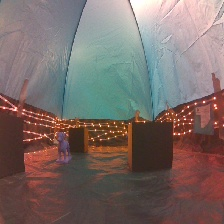
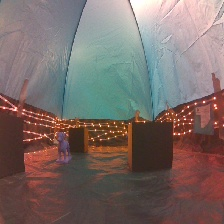
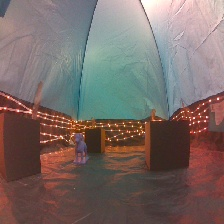
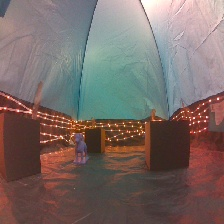
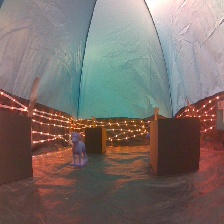
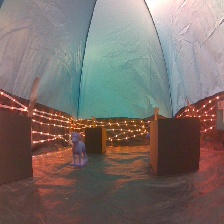
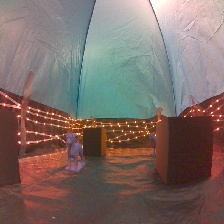
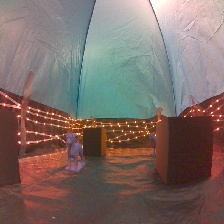
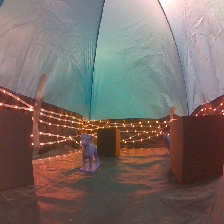
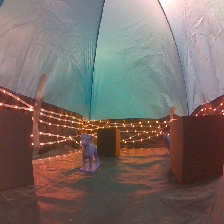
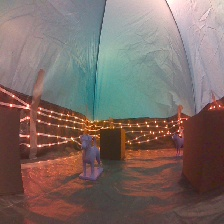
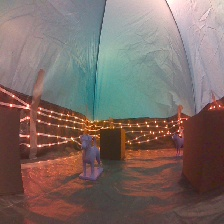
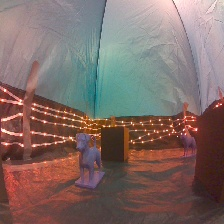
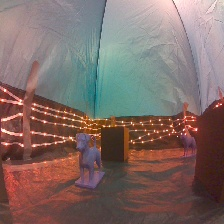
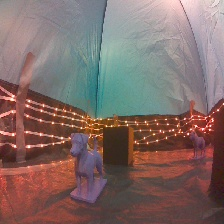
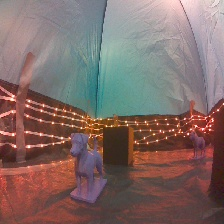
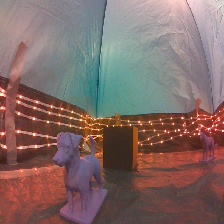
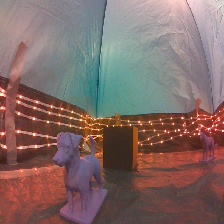
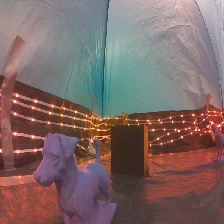
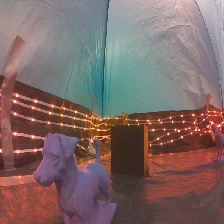
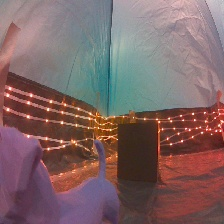
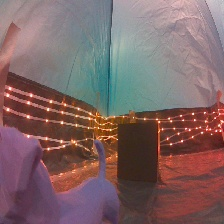
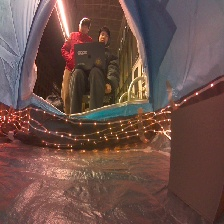
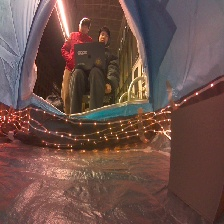
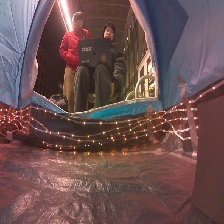
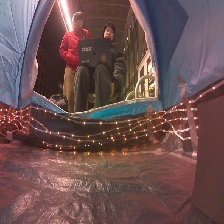
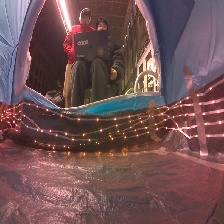
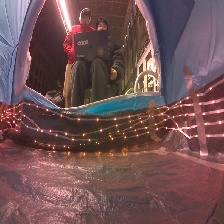
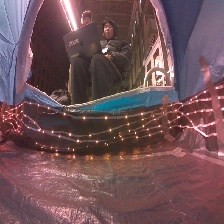
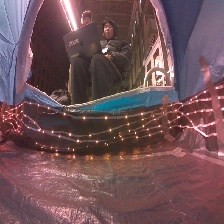
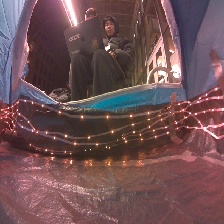
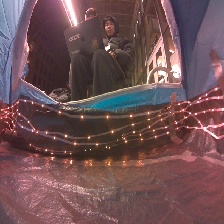
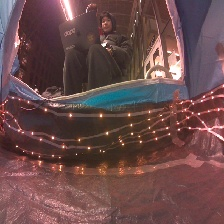
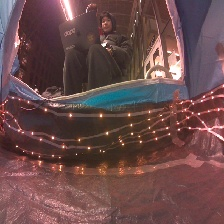
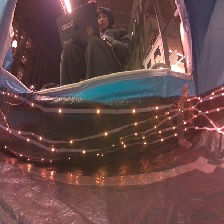
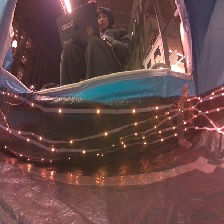
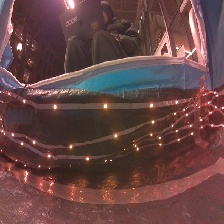
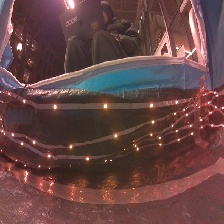
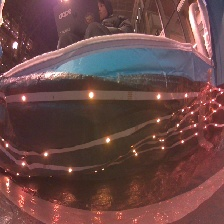
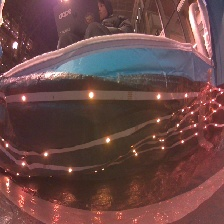
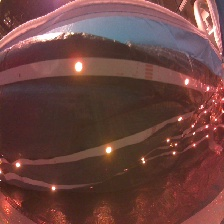
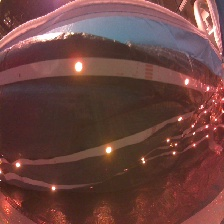
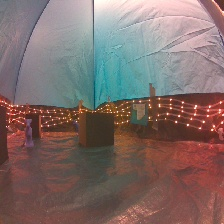
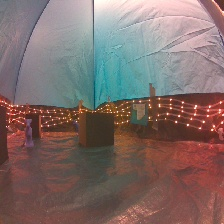
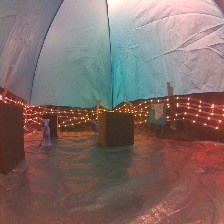
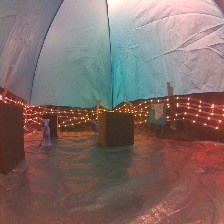
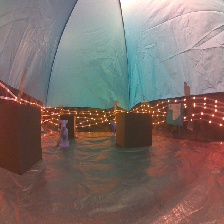
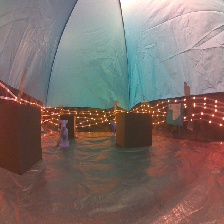
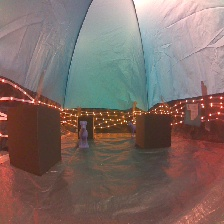
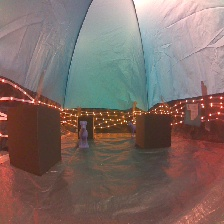
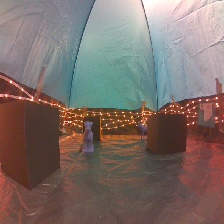
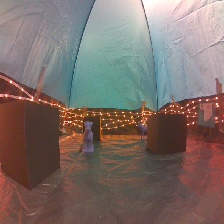
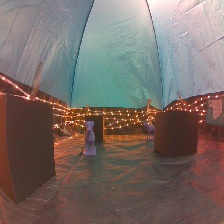
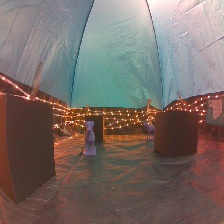
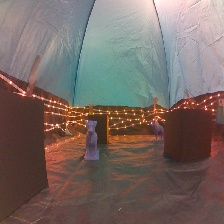
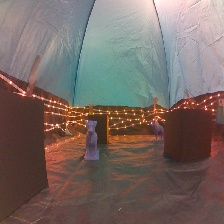
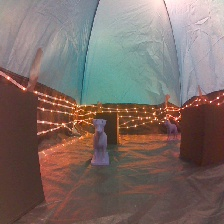
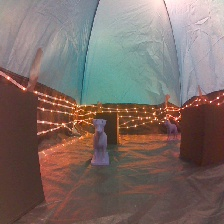
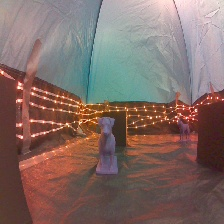
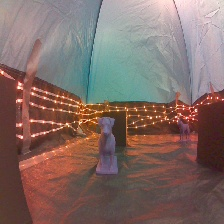
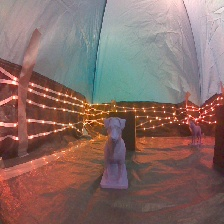
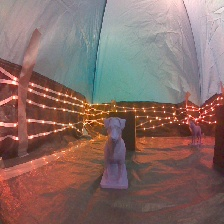
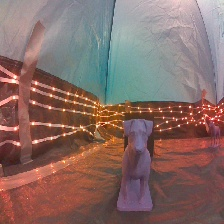
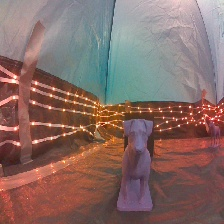
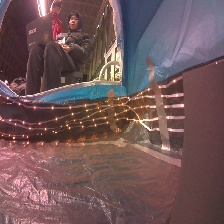
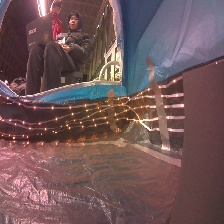
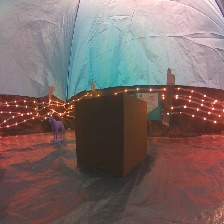
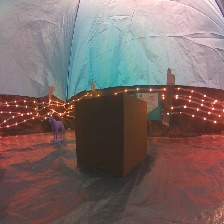
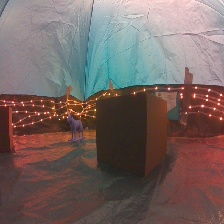
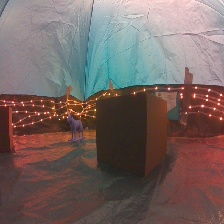
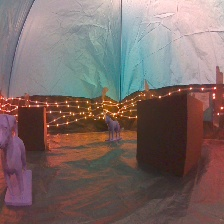
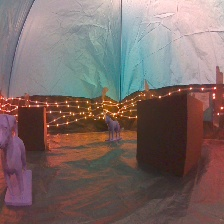
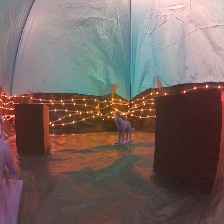
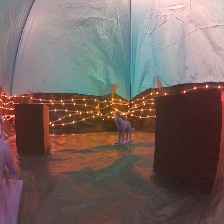
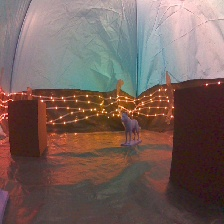
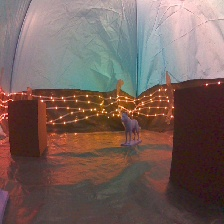
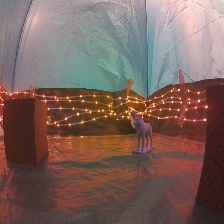
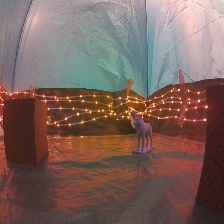
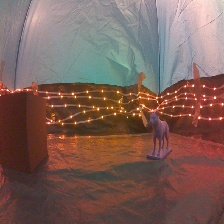
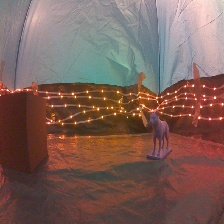
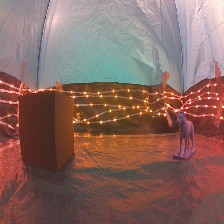
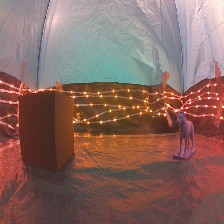
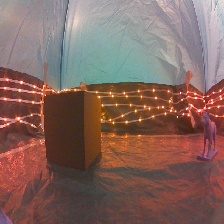
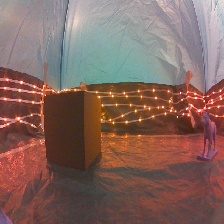
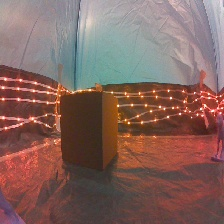
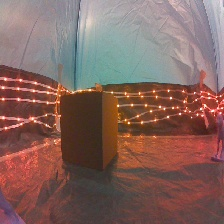
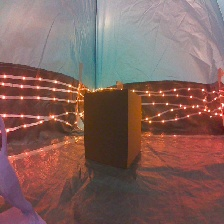
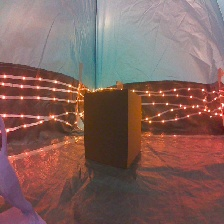
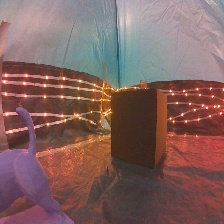
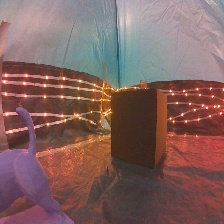
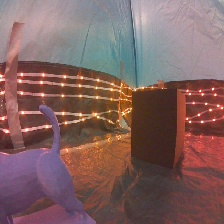
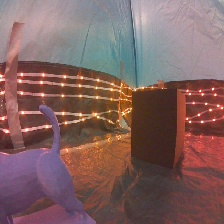
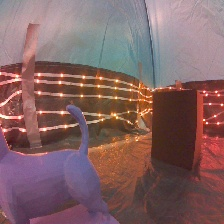
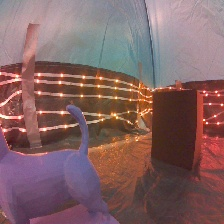
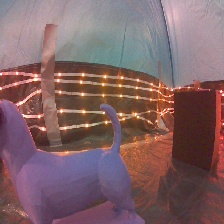
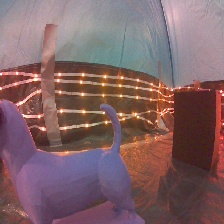
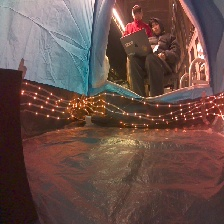
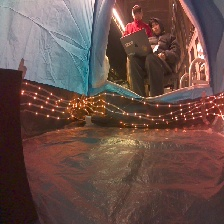
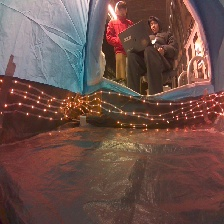
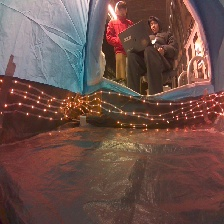
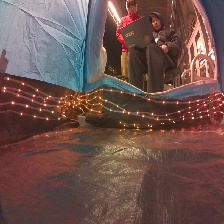
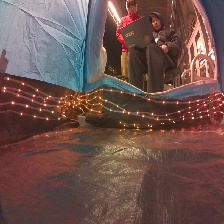

In [ ]:
loop()

In [31]:
server.close_connection()

No active connection to close.
